## problem statement:- classify the Emotion of the comment 

## Importing the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,CategoricalNB,GaussianNB
from sklearn.metrics import accuracy_score
import scipy.stats as ss

## Data collection

In [2]:
# read the data set
data=pd.read_csv(r"C:\Users\LENOVO\Downloads\Emotion_classify_Data.csv")

In [3]:
# make a copy of dataset
datac=data.copy()

In [4]:
datac

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear


## perform EDA to explore the data

In [5]:
datac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


We have 2 columns where one is comment and another is Emotion.Based on the problem statement we can cleary say that Emotion is our class label and comment is our feature variable.

And dataset didn't contain any null values.

In [6]:
# check whether dataset contains duplicates
datac.duplicated().sum()

0

Dataset didn't contain any duplicates

In [7]:
# check the data whether it is balanced or imbalanced data and it should be done on basis of class label.
datac["Emotion"].value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

It is slightly imbalanced data where anger and joy has equal amount of data but for fear it has less data than anger and joy.
so we can conclude that it is an imbalanced data

In [8]:
# As the feature variable comment is text data we need to check whether data contains any html tags,unwanted characters,
# special characters,links and mainly it should be in either uppercase or lower case.to check that i created a function.

# creating a function for performing eda for text pre-processing
def edat(data,name): # DATAFRAME,COLUMn nAME
    case=" ".join(data[name]).islower()
    html_tags=data[name].apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url=data[name].apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted_chars=data[name].apply(lambda x:True if re.search("[]()*\-:;\".,@#$%^&0-9]",x) else False).sum()
    if case==False:
        print("not in lower case")
    if html_tags>0:
        print("have html tags")
    if url>0:
        print("have urls")
    if unwanted_chars>0:
        print("have unwanted characters")

In [9]:
## applying the function to comment column
edat(datac,"Comment")

By performing eda we clearly say that data is in lower case,it didn't have any html tags ,urls and unwanted characters.

In [10]:
# revome not from stopwords

In [11]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stp=stopwords.words("english")
stp.remove("not")

## Text preprocessing

In [14]:
# from the above eda we find that data is cleaned and the only thing we need to do is removing stopwords and 
# extracting feature variable and class variable
def tpp(x): ## tokenization,removing stopwords
    
    l=[]
    for word in word_tokenize(x):
        if word in stp:
            pass
        elif len(word)<=2:
            pass
        else:
            l.append(word)
    
    return " ".join(l)

In [15]:
# applying the function to our text column comment
datac["Comment"]=datac["Comment"].apply(tpp)

In [16]:
# final data of comment column
datac["Comment"]

0       seriously hate one subject death feel reluctan...
1                                 full life feel appalled
2       sit write start dig feelings think afraid acce...
3       ive really angry feel like idiot trusting firs...
4       feel suspicious one outside like rapture happe...
                              ...                        
5932                                begun feel distressed
5933    left feeling annoyed angry thinking center stu...
5934    ever get married everything ready offer got to...
5935    feel reluctant applying want able find company...
5936           wanted apologize feel like heartless bitch
Name: Comment, Length: 5937, dtype: object

In [17]:
datac.head()

,Comment,Emotion
0,seriously hate one subject death feel reluctan...,fear
1,full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry feel like idiot trusting firs...,joy
4,feel suspicious one outside like rapture happe...,fear


In [18]:
# from this data extract the feature variable and class variable
fea_var=datac.iloc[:,0]
cl_var=datac.iloc[:,-1]

In [19]:
fea_var.head()

0    seriously hate one subject death feel reluctan...
1                              full life feel appalled
2    sit write start dig feelings think afraid acce...
3    ive really angry feel like idiot trusting firs...
4    feel suspicious one outside like rapture happe...
Name: Comment, dtype: object

In [20]:
cl_var.head()

0     fear
1    anger
2     fear
3      joy
4     fear
Name: Emotion, dtype: object

In [21]:
# Here as the class label is category we need to give label that should be real value
cl_var=cl_var.map({"fear":0,"anger":1,"joy":2})

In [22]:
cl_var.head()

0    0
1    1
2    0
3    2
4    0
Name: Emotion, dtype: int64

## EDA after preprocessing

In [23]:
# Before performing EDA we need to split the data because EDA should be performed on train dataset only so that the 
# test data will be unseened data

In [24]:
#splitting the data into train and test
x_train,x_test,y_train,y_test=train_test_split(fea_var,cl_var,test_size=0.2,random_state=1,stratify=cl_var)

In [25]:
# splitting train data into train and cv
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

In [26]:
# from this x_train and y_train we need to perform the EDA to know more about the data
# for this firstly concate the x_train and y_train
d_eda=pd.concat([x_train,y_train],axis=1)

In [27]:
d_eda

,Comment,Emotion
4002,definitely feeling festive vibe busy christmas...,2
2259,feel paranoid want feel like back ever,0
5750,joke leaving tell know shes going fall love ci...,0
923,hope feel mellow well fed well slept peace wit...,2
2381,feel litte shaken point,0
...,...,...
5580,tell whenever feel hesitant start muay thai,0
2697,not always able capture essence way see world ...,0
1960,feeling really quite angry,1
3296,glad peter doesnt feel threatened concerned re...,0


In [28]:
# again mapping the values to know which emotion the comment is.
d_eda["Emotion"]=d_eda["Emotion"].map({0:"fear",1:"anger",2:"joy"})

In [29]:
d_eda

,Comment,Emotion
4002,definitely feeling festive vibe busy christmas...,joy
2259,feel paranoid want feel like back ever,fear
5750,joke leaving tell know shes going fall love ci...,fear
923,hope feel mellow well fed well slept peace wit...,joy
2381,feel litte shaken point,fear
...,...,...
5580,tell whenever feel hesitant start muay thai,fear
2697,not always able capture essence way see world ...,fear
1960,feeling really quite angry,anger
3296,glad peter doesnt feel threatened concerned re...,fear


In [30]:
d_eda["Emotion"].value_counts()

Emotion
joy      1280
anger    1280
fear     1239
Name: count, dtype: int64

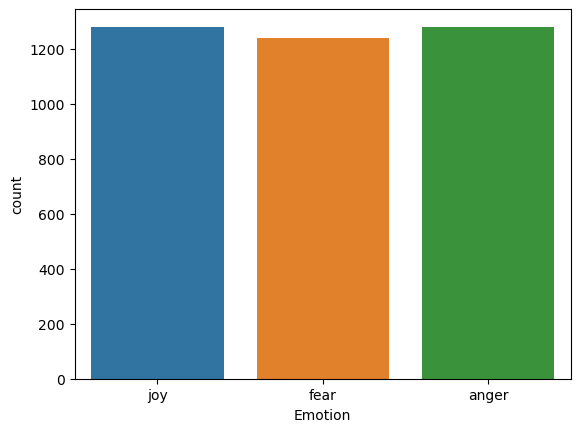

In [31]:
# countplot to visualize no of data points each emotion has
sns.countplot(x=d_eda["Emotion"])
plt.show()

In [32]:
# creating separate dataframe for emotion fear
e_fear=d_eda[d_eda["Emotion"]=="fear"]

In [33]:
e_fear

,Comment,Emotion
2259,feel paranoid want feel like back ever,fear
5750,joke leaving tell know shes going fall love ci...,fear
2381,feel litte shaken point,fear
4147,remember feeling terrified around plants back kid,fear
4689,found feeling inhibited shushing quite lot,fear
...,...,...
583,feeling reluctant whole day today thing feel l...,fear
699,feel like put bag shaken otherwise,fear
5580,tell whenever feel hesitant start muay thai,fear
2697,not always able capture essence way see world ...,fear


In [34]:
# creating separate dataframe for emotion anger
e_anger=d_eda[d_eda["Emotion"]=="anger"]

In [35]:
e_anger

,Comment,Emotion
1159,feeling stressed run support immune system,anger
2949,feeling wonder dangerous place could settled m...,anger
1209,get angry feel bitter,anger
2714,feel like get mad think someones something tha...,anger
869,feeling quite impatient must hit thats interne...,anger
...,...,...
5821,feel like one cares one bothered make effort meet,anger
4542,feeling pretty cranky could think much better ...,anger
3688,feeling cranky,anger
1960,feeling really quite angry,anger


In [36]:
# creating separate dataframe for emotion joy
e_joy=d_eda[d_eda["Emotion"]=="joy"]

In [37]:
e_joy

,Comment,Emotion
4002,definitely feeling festive vibe busy christmas...,joy
923,hope feel mellow well fed well slept peace wit...,joy
1311,hear word feel stronger assured,joy
698,feel fabulous birding weekend everyone,joy
3357,feel lip curl half smile amused way put,joy
...,...,...
1056,feel like smell scent taiwan quite frequently ...,joy
5854,feel damn complacent,joy
2061,sometimes feel like artistic redcoat,joy
4202,never happier feel accepted whole life,joy


In [38]:
# for loop to join the comments that belongs to fear
f=[]
for word in " ".join(e_fear["Comment"]).split():
        f.append(word)

In [39]:
# counting the most common words using counter function
Counter(f).most_common(10)

[('feel', 782),
 ('feeling', 467),
 ('like', 167),
 ('not', 146),
 ('little', 103),
 ('know', 78),
 ('bit', 72),
 ('really', 62),
 ('people', 58),
 ('nervous', 56)]

In [40]:
# for loop to join the comments that belongs to anger
a=[]
for word in " ".join(e_anger["Comment"]).split():
        a.append(word)

In [41]:
# counting the most common words using counter function
Counter(a).most_common(10)

[('feel', 878),
 ('feeling', 429),
 ('like', 233),
 ('not', 171),
 ('really', 79),
 ('time', 72),
 ('know', 70),
 ('people', 69),
 ('get', 67),
 ('little', 61)]

In [42]:
# for loop to join the comments that belongs to joy
j=[]
for word in " ".join(e_joy["Comment"]).split():
        j.append(word)

In [43]:
# counting the most common words using counter function
Counter(j).most_common(10)

[('feel', 942),
 ('feeling', 365),
 ('like', 247),
 ('not', 158),
 ('really', 79),
 ('time', 71),
 ('get', 60),
 ('want', 60),
 ('something', 54),
 ('people', 54)]

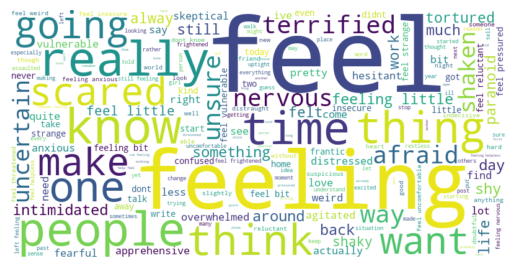

In [44]:
# for visualizing the most repeated or common words in comments of particular emotion we can use wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(e_fear["Comment"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()


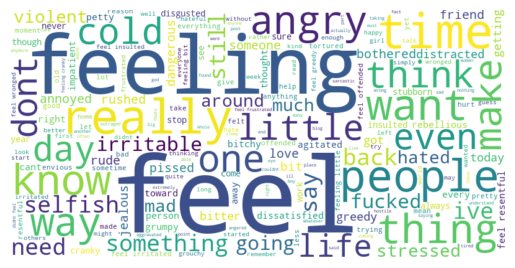

In [45]:
# for visualizing the most repeated or common words in comments of particular emotion we can use wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(e_anger["Comment"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()


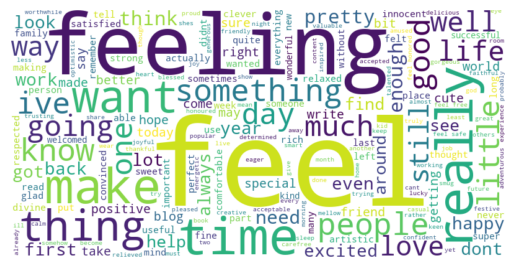

In [46]:
# for visualizing the most repeated or common words in comments of particular emotion we can use wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(e_joy["Comment"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()


## Model creation / Training

#### bag of words (multinomial naive bayes)

In [47]:
# for creating a model all the data should be numeric.AS our data is in text we need to convert it into vectors 
# using countvectorizer we can convert text to vectors using bag of words or binary bag of words

In [48]:
cv=CountVectorizer() # here we have a bag of words technique to convert into vectors

In [49]:
bow_train=cv.fit_transform(x_train)  # fits the vectorizer into doccument

In [50]:
bow_train

<3799x6726 sparse matrix of type '<class 'numpy.int64'>'
	with 34128 stored elements in Compressed Sparse Row format>

In [51]:
bow_cv=cv.transform(x_cv) # transforms cv data to vectors based on the trained data

In [52]:
bow_cv

<950x6726 sparse matrix of type '<class 'numpy.int64'>'
	with 7378 stored elements in Compressed Sparse Row format>

In [53]:
bow_test=cv.transform(x_test) # transforms test data to vectors based on the trained data

In [54]:
bow_test

<1188x6726 sparse matrix of type '<class 'numpy.int64'>'
	with 9517 stored elements in Compressed Sparse Row format>

In [55]:
# as we converted into vectors using bag of words use Multinomial Naive bayes 
# finding training error for multinomial naive bayes where query points are trained points only  
tr_error_mnb=[] 
for alpha in range(1,100):
    mnb=MultinomialNB(alpha=alpha)
    model=mnb.fit(bow_train,y_train)
    predicted=model.predict(bow_train)
    error_tr1=(1-accuracy_score(y_train,predicted))
    tr_error_mnb.append(error_tr1)


In [56]:
# finding cv error for multinomial naive bayes where query points are cv data points
cv_error_mnb=[] 
for alpha in range(1,100):
    mnb=MultinomialNB(alpha=alpha)
    model=mnb.fit(bow_train,y_train)
    predicted=model.predict(bow_cv)
    error_cv1=(1-accuracy_score(y_cv,predicted))
    cv_error_mnb.append(error_cv1)

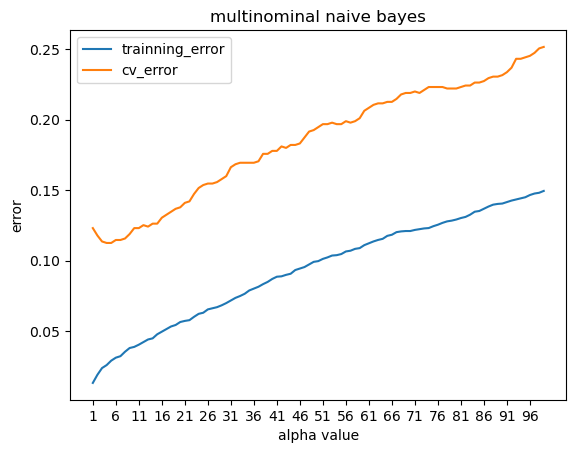

In [57]:
# plot the graph to choose the alpha value where train error and cv error is low
plt.plot(range(1,100),tr_error_mnb,label="trainning_error")
plt.plot(range(1,100),cv_error_mnb,label="cv_error")
plt.xticks(range(1,100,5))
plt.xlabel("alpha value")
plt.ylabel("error")
plt.legend()
plt.title("multinominal naive bayes")
plt.show()

In [58]:
# from plot we can see that both train and cv error is low at alpha is 1 
# so by choosing alpha as 1 test the model accuracy by passing test data

mnb=MultinomialNB(alpha=1)
model=mnb.fit(bow_train,y_train)
predicted=model.predict(bow_test)
acc=accuracy_score(y_test,predicted)

In [59]:
acc

0.8905723905723906

##### Bag of words (categorical naive bayes) 

In [60]:
# finding training error for categorical naive bayes where query points are trained points only  
tr_error_cnb=[] 
for alpha in range(1,100):
    cnb=CategoricalNB(alpha=alpha)
    model=cnb.fit(bow_train.toarray(),y_train)
    predicted=model.predict(bow_train.toarray())
    error_tr3=(1-accuracy_score(y_train,predicted))
    tr_error_cnb.append(error_tr3)

In [61]:
# finding cv error for categorical naive bayes where query points are cv data points
cv_error_cnb=[] 
for alpha in range(1,100):
    cnb=CategoricalNB(alpha=alpha,min_categories=10)
    model=cnb.fit(bow_train.toarray(),y_train)
    predicted=model.predict(bow_cv.toarray())
    error_cv3=(1-accuracy_score(y_cv,predicted))
    cv_error_cnb.append(error_cv3)

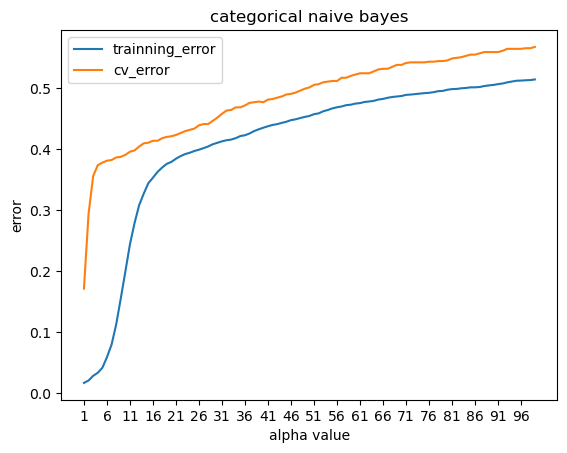

In [62]:
# plot the graph to choose the alpha value where train error and cv error is low
plt.plot(range(1,100),tr_error_cnb,label="trainning_error")
plt.plot(range(1,100),cv_error_cnb,label="cv_error")
plt.xticks(range(1,100,5))
plt.xlabel("alpha value")
plt.ylabel("error")
plt.legend()
plt.title("categorical naive bayes")
plt.show()

In [63]:
# from plot we can see that both train and cv error is low at alpha is 1 
# so by choosing alpha as 1 test the model accuracy by passing test data

cnb=CategoricalNB(alpha=1,min_categories=10)
model=cnb.fit(bow_train.toarray(),y_train)
predicted=model.predict(bow_test.toarray())
acc=accuracy_score(y_test,predicted)

In [64]:
acc

0.8535353535353535

#### binary bag of words(Bernoulli naive bayes)

In [65]:
cv1=CountVectorizer(binary=True)# here we have a binary bag of words technique to convert into vectors

In [66]:
bbow_train=cv1.fit_transform(x_train)  # fits the vectorizer into doccument

In [67]:
bbow_train

<3799x6726 sparse matrix of type '<class 'numpy.int64'>'
	with 34128 stored elements in Compressed Sparse Row format>

In [68]:
bbow_cv=cv1.transform(x_cv) # transforms cv data to vectors based on the trained data

In [69]:
bbow_cv

<950x6726 sparse matrix of type '<class 'numpy.int64'>'
	with 7378 stored elements in Compressed Sparse Row format>

In [70]:
bbow_test=cv1.transform(x_test) # transforms test data to vectors based on the trained data

In [71]:
bbow_test

<1188x6726 sparse matrix of type '<class 'numpy.int64'>'
	with 9517 stored elements in Compressed Sparse Row format>

In [72]:
# as we converted into vectors using binary bag of words use Bernoulli Naive bayes 
# finding training error for bernoulli naive bayes where query points are trained points only  
tr_error_bnb=[] 
for alpha in range(1,100):
    bnb=BernoulliNB(alpha=alpha)
    model=bnb.fit(bbow_train,y_train)
    predicted=model.predict(bbow_train)
    error_tr2=(1-accuracy_score(y_train,predicted))
    tr_error_bnb.append(error_tr2)

In [73]:
# finding cv error for bernoulli naive bayes where query points are cv data points
cv_error_bnb=[] 
for alpha in range(1,100):
    bnb=BernoulliNB(alpha=alpha)
    model=bnb.fit(bbow_train,y_train)
    predicted=model.predict(bbow_cv)
    error_cv2=(1-accuracy_score(y_cv,predicted))
    cv_error_bnb.append(error_cv2)

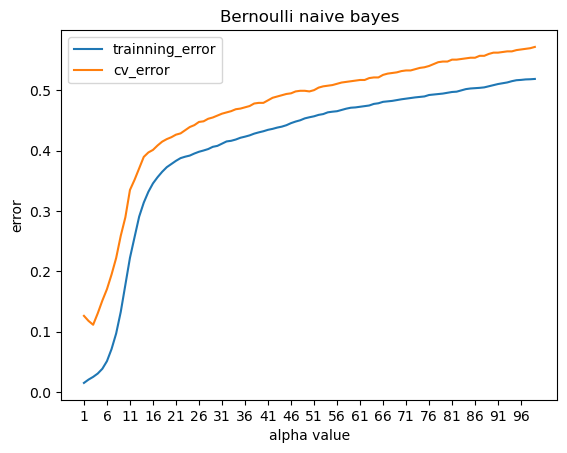

In [74]:
# plot the graph to choose the alpha value where train error and cv error is low
plt.plot(range(1,100),tr_error_bnb,label="trainning_error")
plt.plot(range(1,100),cv_error_bnb,label="cv_error")
plt.xticks(range(1,100,5))
plt.xlabel("alpha value")
plt.ylabel("error")
plt.legend()
plt.title("Bernoulli naive bayes")
plt.show()

In [75]:
# from plot we can see that both train and cv error is low at alpha is 1 
# so by choosing alpha as 1 test the model accuracy by passing test data

bnb=BernoulliNB(alpha=1)
model=bnb.fit(bbow_train,y_train)
predicted=model.predict(bbow_test)
acc=accuracy_score(y_test,predicted)

In [76]:
acc

0.8905723905723906

#### binary bag of words (multinomial naive bayes)

In [77]:
# finding training error for Multinomial naive bayes where query points are trained points only  
tr_error_mnb=[] 
for alpha in range(1,100):
    mnb=MultinomialNB(alpha=alpha)
    model=mnb.fit(bbow_train,y_train)
    predicted=model.predict(bbow_train)
    error_tr4=(1-accuracy_score(y_train,predicted))
    tr_error_mnb.append(error_tr4)

In [78]:
# finding cv error for multinomial naive bayes where query points are cv data points
cv_error_mnb=[] 
for alpha in range(1,100):
    mnb=MultinomialNB(alpha=alpha)
    model=mnb.fit(bbow_train,y_train)
    predicted=model.predict(bbow_cv)
    error_cv4=(1-accuracy_score(y_cv,predicted))
    cv_error_mnb.append(error_cv4)

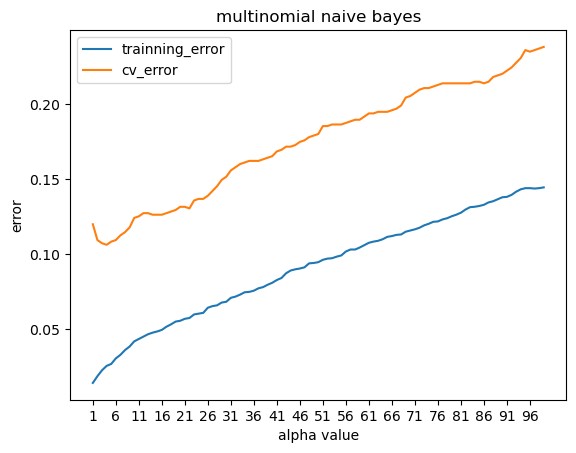

In [79]:
# plot the graph to choose the alpha value where train error and cv error is low
plt.plot(range(1,100),tr_error_mnb,label="trainning_error")
plt.plot(range(1,100),cv_error_mnb,label="cv_error")
plt.xticks(range(1,100,5))
plt.xlabel("alpha value")
plt.ylabel("error")
plt.legend()
plt.title("multinomial naive bayes")
plt.show()

In [80]:
# from plot we can see that both train and cv error is low at alpha is 1 
# so by choosing alpha as 1 test the model accuracy by passing test data

mnb=MultinomialNB(alpha=1)
model=mnb.fit(bbow_train,y_train)
predicted=model.predict(bbow_test)
acc=accuracy_score(y_test,predicted)

In [81]:
acc

0.8939393939393939